### Import Packages

In [1]:
from my_krml_24886400.data.sets import get_data_from_gdrive, merge_dataframes_on_common_columns, remove_outliers
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
file_path = '../../data'
os.makedirs(file_path, exist_ok=True)

# load raw data files
df_train = get_data_from_gdrive(url='https://drive.google.com/file/d/1-0x5Vfri1i-OL3ek2GnhZGye-4eqbqQA/view', file_path=file_path)
df_items = get_data_from_gdrive('https://drive.google.com/file/d/1--W-RjAnypyvbwUCsSZVldrA2Ja2jtDA/view', file_path)
df_cal = get_data_from_gdrive('https://drive.google.com/file/d/1-6cH8c0tKTFu8EzMJyVfdhxrny6rdgrM/view', file_path)
df_events = get_data_from_gdrive('https://drive.google.com/file/d/1_RmDGfRTMkqF4OO9NibNoRhbEjc0OZW4/view', file_path)

../../data/1-0x5Vfri1i-OL3ek2GnhZGye-4eqbqQA.csv already exists. Reading the file from the local directory.
../../data/1--W-RjAnypyvbwUCsSZVldrA2Ja2jtDA.csv already exists. Reading the file from the local directory.
../../data/1-6cH8c0tKTFu8EzMJyVfdhxrny6rdgrM.csv already exists. Reading the file from the local directory.
../../data/1_RmDGfRTMkqF4OO9NibNoRhbEjc0OZW4.csv already exists. Reading the file from the local directory.


### Prepare Dataset

In [3]:
# Melt the train_df to have a long format
df_train = pd.melt(df_train,
         id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
         var_name='d',
         value_name='item_sold')

In [4]:
dataframe_list = [df_train, df_cal, df_events, df_items]

sales_data = merge_dataframes_on_common_columns(dataframe_list)
sales_data.shape

['d']
['date']
['store_id', 'item_id', 'wm_yr_wk']


(47107050, 13)

In [5]:
sales_data['sales_revenue'] = sales_data['item_sold'] * sales_data['sell_price']

In [6]:
# Convert 'date' to datetime if not already
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Aggregate sales_revenue by date
daily_sales = sales_data.groupby(['date', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sales_revenue'].sum().reset_index()

# Sort by date
daily_sales.sort_values('date', inplace=True)

# Extract features from date
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['day_of_week'] = daily_sales['date'].dt.dayofweek
daily_sales['week_of_year'] = daily_sales['date'].dt.isocalendar().week
daily_sales['is_weekend'] = np.where(daily_sales['day_of_week'].isin([5, 6]), 1, 0)

# Set 'date' as the index
daily_sales.set_index('date', inplace=True)

In [7]:
daily_sales = remove_outliers(daily_sales, 'sales_revenue')

In [8]:
daily_sales_sample_size = int(0.001 * len(daily_sales))
daily_sales_sample = daily_sales.iloc[:daily_sales_sample_size]

In [9]:
# Define features and target variable
X = daily_sales_sample[['year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
y = daily_sales_sample['sales_revenue']

In [10]:
X = daily_sales[['year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
y = daily_sales['sales_revenue']

In [11]:
# Define categorical and numerical columns
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
numerical_features = ['year', 'month', 'day', 'day_of_week', 'week_of_year', 'is_weekend']

In [12]:
# Preprocessing for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

### Build Pipeline

In [13]:
# Use ColumnTransformer to apply the right transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [14]:
# Assuming your data is already sorted by date
train_size = int(0.8 * len(daily_sales_sample))  # Use 80% of the data for training

train_data = daily_sales_sample.iloc[:train_size]
test_data = daily_sales_sample.iloc[train_size:]

X_train = daily_sales_sample.drop(columns=['sales_revenue'])  # Drop the target and date column
y_train = daily_sales_sample['sales_revenue']

X_test = daily_sales_sample.drop(columns=['sales_revenue'])
y_test = daily_sales_sample['sales_revenue']

In [15]:
X_train[categorical_features + numerical_features]
X_test[categorical_features + numerical_features]

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,day_of_week,week_of_year,is_weekend
date,,,,,,,,,,,
2011-01-29,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011,1,29,5,4,1
2011-01-29,HOUSEHOLD_1_033,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,2011,1,29,5,4,1
2011-01-29,HOUSEHOLD_1_033,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,2011,1,29,5,4,1
2011-01-29,HOUSEHOLD_1_032,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,2011,1,29,5,4,1
2011-01-29,HOUSEHOLD_1_032,HOUSEHOLD_1,HOUSEHOLD,WI_2,WI,2011,1,29,5,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2011-01-30,HOUSEHOLD_2_014,HOUSEHOLD_2,HOUSEHOLD,CA_2,CA,2011,1,30,6,4,1
2011-01-30,HOUSEHOLD_2_014,HOUSEHOLD_2,HOUSEHOLD,CA_1,CA,2011,1,30,6,4,1
2011-01-30,HOUSEHOLD_2_013,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,2011,1,30,6,4,1


### Train Model

In [16]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'day_of_week',
                                                   'week_of_year',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['item_id', 'dept_id',
                                                   'cat_id', 'store_id',
                                                   'state_id'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [17]:
# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate performance (e.g., RMSE)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.4568532993774595


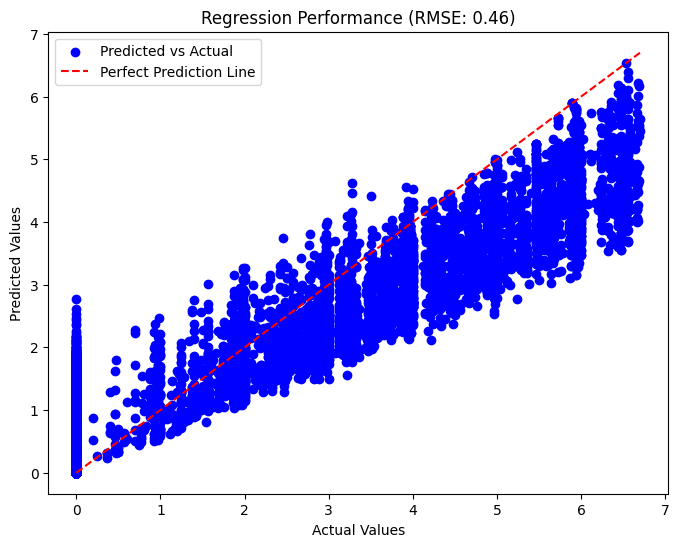

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="blue", label="Predicted vs Actual")

# Plot a diagonal line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--", label="Perfect Prediction Line")

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Regression Performance (RMSE: {rmse:.2f})')

# Add a legend
plt.legend()

# Show the plot
plt.show()

The Random Forest is performing better in compared to other experiment but is trained only on sample data.

In [19]:
joblib.dump(pipeline, '../../models/predictive/rf.joblib')

['../../models/predictive/rf.joblib']